# Regularizing Linear Models

## Setup

In [1]:
import os
if os.getcwd().endswith("notebooks"):
    os.chdir('..')

print("Current working directory: ", os.getcwd())
if not os.getcwd().endswith("ML-Regression-Notebooks"):
    raise ValueError("Please change working directory to 'path/Classifying-the-MNIST' before proceeding")

Current working directory:  /Users/irellzane/MLprojects/ML-Regression-Notebooks


In [2]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Generate Data

In [6]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
xs = np.linspace(0, 3, 100).reshape(-1 , 1)

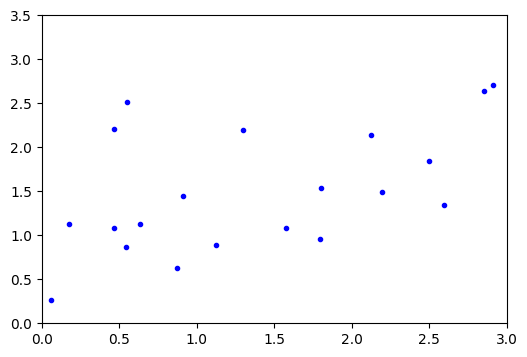

In [15]:
plt.figure(figsize=(6, 4))
plt.axis([0, 3, 0, 3.5])
plt.plot(X, y, "b.")
plt.show()